In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.tensor(data / 1023.0, dtype=torch.float32).view(-1, 1, 32, 32)  # 0~1023 -> 0~1 정규화
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.data[idx]
        return self.data[idx], self.labels[idx]

In [3]:
# ResNet34 모델 정의
class ResNet34Model(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet34Model, self).__init__()
        self.model = models.resnet34(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널 변경 (1채널)
        self.model.fc = nn.Linear(512, num_classes)  # 출력 클래스 조정
    
    def forward(self, x):
        return self.model(x)

In [4]:
# 데이터 불러오기
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
train_features = train_df.drop(columns=['ID', 'label']).values
test_features = test_df.drop(columns=['ID']).values

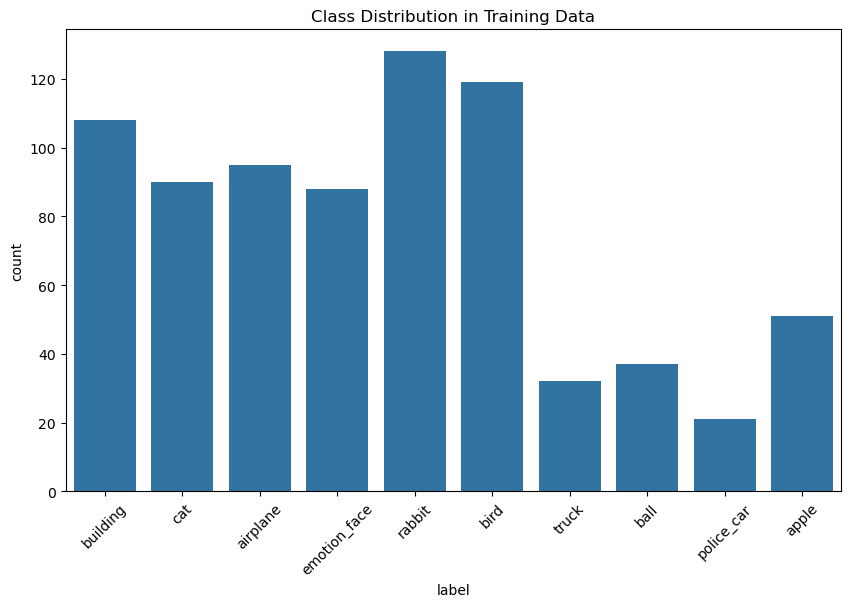

In [6]:
# 데이터 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['label'])
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

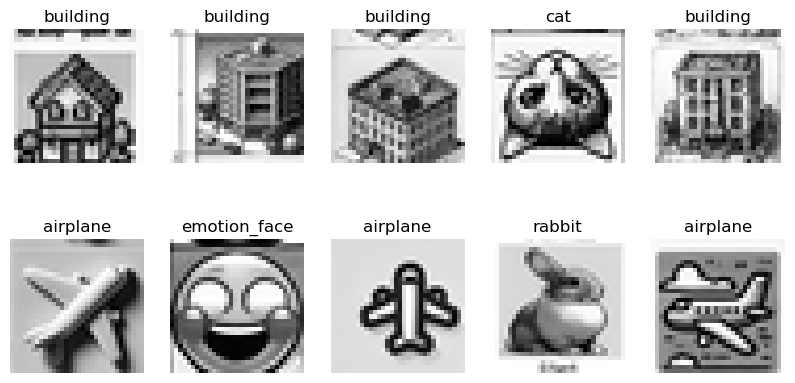

In [7]:
# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = train_features[i].reshape(32, 32)
    ax.imshow(img, cmap='gray')
    ax.set_title(label_encoder.inverse_transform([train_labels[i]])[0])
    ax.axis('off')
plt.show()

In [8]:
# 데이터 증강 함수
def add_noise(data, noise_level=0.1):
    noise = np.random.normal(0, noise_level, size=data.shape)
    return data + noise

def scale_data(data, scale_factor=0.5):
    return data * scale_factor

# 데이터 증강 적용
augmented_train_features = []
augmented_train_labels = []
for feature, label in zip(train_features, train_labels):
    # 노이즈 추가
    noisy_feature = add_noise(feature)
    # 스케일링
    scaled_feature = scale_data(feature)
    
    augmented_train_features.extend([feature, noisy_feature, scaled_feature])
    augmented_train_labels.extend([label, label, label])

# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(augmented_train_features, augmented_train_labels, test_size=0.2, random_state=42)

In [9]:
# 데이터셋 및 데이터로더 생성
# NumPy 배열로 변환
X_train = np.array(X_train)
X_val = np.array(X_val)
test_features = np.array(test_features)

train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(test_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

num_epochs = 15
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    # 검증 단계
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

c:\Users\09048\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\09048\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.3528, Val Loss: 2.1795, Val Accuracy: 0.3377
Epoch 2/15, Train Loss: 0.4236, Val Loss: 0.6818, Val Accuracy: 0.7857
Epoch 3/15, Train Loss: 0.1877, Val Loss: 0.4502, Val Accuracy: 0.8680
Epoch 4/15, Train Loss: 0.2001, Val Loss: 0.2461, Val Accuracy: 0.9134
Epoch 5/15, Train Loss: 0.1307, Val Loss: 0.3034, Val Accuracy: 0.9026
Epoch 6/15, Train Loss: 0.0540, Val Loss: 0.0451, Val Accuracy: 0.9827
Epoch 7/15, Train Loss: 0.0067, Val Loss: 0.0169, Val Accuracy: 0.9935
Epoch 8/15, Train Loss: 0.0106, Val Loss: 0.0407, Val Accuracy: 0.9870
Epoch 9/15, Train Loss: 0.0568, Val Loss: 0.2602, Val Accuracy: 0.9113
Epoch 10/15, Train Loss: 0.0657, Val Loss: 0.0629, Val Accuracy: 0.9827
Epoch 11/15, Train Loss: 0.0586, Val Loss: 0.0548, Val Accuracy: 0.9848
Epoch 12/15, Train Loss: 0.0506, Val Loss: 0.0806, Val Accuracy: 0.9784
Epoch 13/15, Train Loss: 0.0262, Val Loss: 0.0466, Val Accuracy: 0.9935
Epoch 14/15, Train Loss: 0.0023, Val Loss: 0.0328, Val Accuracy: 0.9935
E

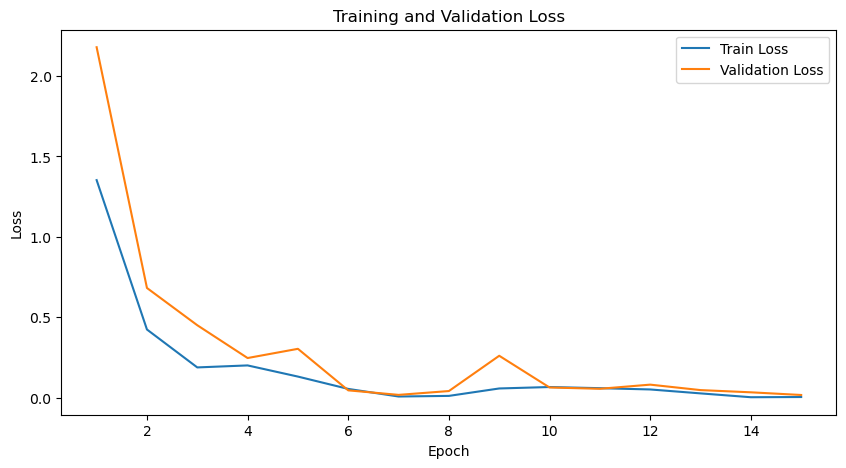

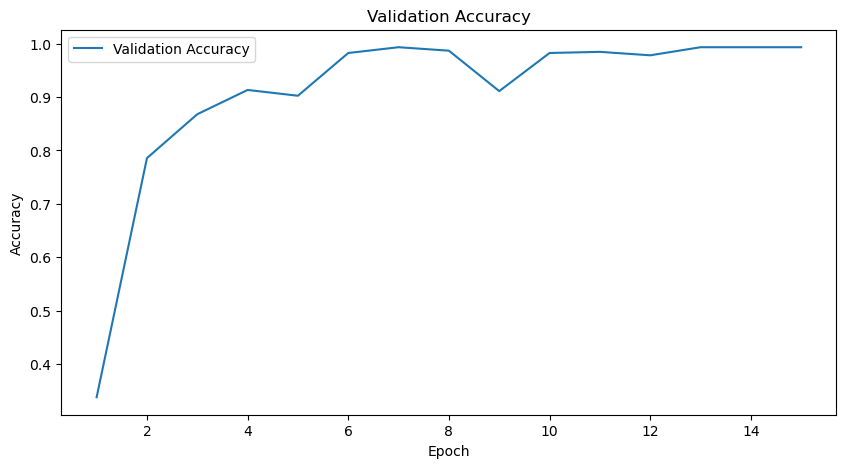

In [14]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [15]:
# 예측 및 저장
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

In [16]:
# 결과 저장
submission = pd.DataFrame({"ID": test_df["ID"], "label": label_encoder.inverse_transform(predictions)})
submission.to_csv("submission.csv", index=False)